# Feasibility loss analyses

In [34]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy.stats import anderson
from scipy import stats
import sys

In [ ]:
# Function to read simulation parameters from file
def read_parameters(filename):
    with open(filename, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    
    # First line is for N
    N = int(lines[0].split('=')[1].strip())
    
    # Find line for A
    try:
        A_idx = lines.index("A =") + 1
    except ValueError:
        sys.exit("Error: 'A =' not found in parameters file.")
    
    # Next N lines are the rows of A
    A_rows = []
    for i in range(N):
        row = [float(x) for x in lines[A_idx + i].split()]
        A_rows.append(row)
    mu_A = np.array(A_rows)  # assume rows correspond directly
    
    # Find equilibrium vector line given for equilibrium
    try:
        eq_idx = lines.index("equilibrium =") + 1
    except ValueError:
        sys.exit("Error: 'equilibrium =' not found in parameters file.")
    
    equilibrium = []
    for i in range(N):
        equilibrium.append(float(lines[eq_idx + i]))
    equilibrium = np.array(equilibrium)
    
    # Compute r
    r = mu_A.dot(-equilibrium)
    
    return N, mu_A, equilibrium, r

## Monte Carlo Simulations

In [ ]:
# Function to simulate feasibility loss time for a exact single simulation using stochastic differential equation.
def simulate_loss_time(mu_A, drift, diffusion, y_initial, r, dt):
    """
    Simulates the feasibility loss time for a single simulation and identifies which components of y_new were non positive.
    mu_A: 2D array (shape: [N, N]) for the mean of A.
    drift: 2D array (shape: [N, N])
    diffusion: 2D array (shape: [N, N])
    y_initial: 1D array (length N)
    r: 1D array (length N) constant vector
    dt: float given for time step
    """
    N = mu_A.shape[0]
    A_current = mu_A.copy()
    time = 0.0
    # Initialize as all False
    y_components_below_zero_at_loss = np.zeros(N, dtype=bool)

    while True:
        dW = np.random.normal(0.0, np.sqrt(dt), size=(N, N))
        drift_term = drift * (mu_A - A_current)
        A_new = A_current + drift_term * dt + diffusion * dW
        try:
            y_new = np.linalg.solve(A_new, -r)
            if np.any(y_new <= 0.0):
                y_components_below_zero_at_loss = (y_new <= 0.0)
                return time + dt, y_components_below_zero_at_loss
        except np.linalg.LinAlgError:
            # If A_new is singular, y_new is not computed. 
            # Return current time and the false y_components_below_zero_at_loss
            return time, y_components_below_zero_at_loss
        
        A_current = A_new.copy()
        time += dt

In [ ]:
# Function to perform exponential fit and hypothesis testing.
def exp_fit_and_test(data):
    """
    Fits an exponential distribution to the 1D data (loss times)
    and performs an Anderson–Darling test for goodness-of-fit.
    
    Returns:
      lambd  : The estimated rate parameter λ (i.e. λ = 1/mean(data))
      x      : A numpy array of x-values used for plotting the fitted PDF.
      pdf_fitted : The fitted exponential PDF computed as λ * exp(-λ * x).
    """
    # Maximum likelihood estimator for an exponential distribution λ = 1/mean
    lambd = 1.0 / np.mean(data)
    
    # Perform Anderson Darling test 
    ad_test_result = anderson(data, dist='expon')
    print("Anderson-Darling test result:", ad_test_result)
    
    # Generate x values for plotting the fitted PDF
    x = np.linspace(np.min(data), np.max(data), 1000)
    pdf_fitted = lambd * np.exp(-lambd * x)
    
    return lambd, x, pdf_fitted

In [ ]:
# Uses exact stochastic simulation to generate many time series and find average persistence time
# Main simulation function
def main(mu_A, drift, diffusion, r, equilibrium, num_simulations):
    dt = 0.01
    y_initial = equilibrium.copy()
    N = mu_A.shape[0] # Determine N from the input matrix
    
    persistence_times = np.empty(num_simulations, dtype=float)
    # Counter for how many times each component of y_new is <= 0 at loss
    component_non_positive_counts = np.zeros(N, dtype=int)
    
    for i in range(num_simulations):
        current_loss_time, y_components_status = simulate_loss_time(
            mu_A, drift, diffusion, y_initial, r, dt
        )
        persistence_times[i] = current_loss_time
        # If a component was True, add 1 to its count
        component_non_positive_counts += y_components_status.astype(int)
    
    #Calculate average persistence (loss) time
    mean_persistence_time = np.mean(persistence_times)
    
    # Calculate the loss ratios of each species
    component_non_positive_percentages = component_non_positive_counts / num_simulations

    #Calculate standard error for loss times
    std_persistence_times = np.std(persistence_times, ddof=1) 
    sem_persistence_time = std_persistence_times / np.sqrt(num_simulations)

    #Calculate standard error for loss ratios
    sem_loss_ratios = np.zeros(N, dtype=float)
    if num_simulations > 0:
        for k_idx in range(N): 
            p_k = component_non_positive_percentages[k_idx]
            # Binomial proportion standard error sqrt(p*(1-p)/n)
            # Ensure argument of sqrt is non negative (can happen if p_k is slightly > 1 or < 0 due to float precision with counts)
            variance_p_k = p_k * (1 - p_k)
            if variance_p_k < 0: variance_p_k = 0 
            sem_loss_ratios[k_idx] = np.sqrt(variance_p_k / num_simulations)
    
    #The original functionality of printing mean loss time is preserved
    print(f"Mean persistence time: {mean_persistence_time:.4f}")

    # Plot histogram of loss times
    plt.figure(figsize=(4,3))
    plt.hist(persistence_times, bins=50, density=True, color="skyblue", alpha=0.6, label="F. Loss Times")
    plt.xlabel("Feasibility loss time")
    plt.ylabel("Probability Density")
    plt.title("Distribution of Feasibility loss Times")
    
    # Fit exponential distribution to loss times
    lambd, x_vals, pdf_fitted = exp_fit_and_test(persistence_times)
    print(f"Lambda: {lambd:.4f}")
    plt.plot(x_vals, pdf_fitted, lw=2, color="red", label="Exponential Fit")
    plt.legend(loc="upper left")
    plt.show()
    
    # # Create Q-Q plot for loss times against theoretical exponential distribution
    # plt.figure(figsize=(4,3))
    # stats.probplot(persistence_times, dist="expon", sparams=(1.0/lambd,), plot=plt)
    # plt.xlabel("Theoretical Quantiles")
    # plt.ylabel("Empirical Quantiles")
    # plt.title(f"Q-Q Plot (λ = {lambd:.3f})")
    # plt.tight_layout()
    # plt.show()
        
    return mean_persistence_time, component_non_positive_percentages, sem_persistence_time, sem_loss_ratios # Returns the mean extinction time as before

Mean persistence time: 9.2278
Anderson-Darling test result: AndersonResult(statistic=12.040707329426255, critical_values=array([0.921, 1.077, 1.34 , 1.605, 1.956]), significance_level=array([15. , 10. ,  5. ,  2.5,  1. ]), fit_result=  params: FitParams(loc=0.0, scale=9.227830000000028)
 success: True
 message: '`anderson` successfully fit the distribution to the data.')
Lambda: 0.1084


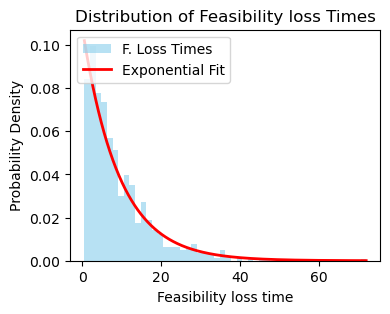

Mean persistence time from MC simulations: 9.2278
Error for mean persistence time: 0.2664003433444441
Species Feasibility Loss Frequencies: [0.004 0.065 0.    0.    0.    0.03  0.    0.005 0.075 0.02  0.756 0.057]
Standard Errors of Loss Frequencies: [0.001996   0.00779583 0.         0.         0.         0.00539444
 0.         0.00223047 0.00832917 0.00442719 0.01358175 0.00733151]


In [ ]:
# Run the simulation with below parameters
if __name__ == '__main__':
    # Read parameters from file parameters.txt
    params_file = "parameters.txt"
    N, mu_A, equilibrium, r = read_parameters(params_file)
    
    diffusion_constant = 0.10
    diffusion = diffusion_constant * np.abs(mu_A)
    D = np.square(diffusion)

    #np.random.seed(25)
    #drift = np.full((N,N), 0.2)
    drift = np.abs(np.random.normal(0.2, 0.02, (N,N)))

    num_simulations = 1000

    # Run the main simulation. It will print the percentages and return the mean persistence time
    persistence_time_mc, loss_ratios_mc, sem_persistence_time, sem_loss_ratios = main(mu_A, drift, diffusion, r, equilibrium, num_simulations)
    print(f"Mean persistence time from MC simulations: {persistence_time_mc:.4f}")
    print(f"Error for mean persistence time: {sem_persistence_time}")
    print(f"Species Feasibility Loss Frequencies: {loss_ratios_mc}")
    print(f"Standard Errors of Loss Frequencies: {sem_loss_ratios}")

### Analytical predictions

In [ ]:
# Find Tloss prediction using gaussian approximating resulting in parabolic potential wells. Uses above defined parameters
def calculate_t_loss_linearized_ou(N_val, A_val, equilibrium_val, D_val, k_val):
    r"""
    Parameters:
    N_val is the ecosystem size.
    A_val is the mean interaction matrix (N x N), denoted as $A_0$ or $\mu_A$.
    equilibrium_val is the noise free equilibrium vector (length N), $\vec{x}_0$.
    D_val is the matrix of squared noise amplitudes for underlying OU processes of $A_{ij}$ (N x N). $D_{pq} = \sigma_{OU,pq}^2$.
    k_val is the matrix of OU relaxation rates $k_{pq}$ for $A_{ij}$ (N x N).
    """

    # Step 1 is to calculate stationary variances of $\delta A_{pq}(t)$
    # $\sigma_{W,pq}^2 = Var(\delta A_{pq})_{stat} = \sigma_{OU,pq}^2 / (2 k_{pq}) = D_{pq} / (2 k_{pq})$
    sigma_W_sq_val = np.zeros_like(D_val)
    # Create a mask for non zero k_val elements to avoid division by zero if D_val is non zero
    valid_k_mask = k_val > 1e-15 # Use a small epsilon to treat near zero k as zero
    
    # Calculate variance only for valid k values
    sigma_W_sq_val[valid_k_mask] = D_val[valid_k_mask] / (2 * k_val[valid_k_mask])
    # Ensure no negative variances from numerical issues
    sigma_W_sq_val[sigma_W_sq_val < 0] = 1e-30
    
    # Step 2: Compute sensitivity coefficients $S_{m,pq} = -(A_0^{-1}E_{pq}\vec{x}_0)_m = -(A_0^{-1})_{mp} x_{0,q}$
    try:
        A0_inv_val = scipy.linalg.inv(A_val)
    except scipy.linalg.LinAlgError:
        return np.nan
    
    S_tensor = np.zeros((N_val, N_val, N_val)) # S_tensor[m, p, q] = S_m,pq
    for m_idx in range(N_val):
        for p_idx in range(N_val):
            for q_idx in range(N_val):
                S_tensor[m_idx, p_idx, q_idx] = -A0_inv_val[m_idx, p_idx] * equilibrium_val[q_idx]

    lambda_k_list = []
    for k_idx in range(N_val): 
        # Step 3a: Calculate marginal stationary variance $\sigma_k^2 = \sum_{p,q} S_{k,pq}^2 \sigma_{W,pq}^2$
        current_sigma_k_sq = 0.0
        for p_idx in range(N_val):
            for q_idx in range(N_val):
                current_sigma_k_sq += (S_tensor[k_idx, p_idx, q_idx]**2) * sigma_W_sq_val[p_idx, q_idx]
        
        sigma_k_sq = current_sigma_k_sq


        sigma_k = np.sqrt(sigma_k_sq) # Standard deviation for component k

        # Step 3b: Calculate marginal effective relaxation rate $\gamma_k = (\sum_{p,q} S_{k,pq}^2 k_{pq}\sigma_{W,pq}^2) / \sigma_k^2$
        numerator_gamma_k = 0.0
        for p_idx in range(N_val):
            for q_idx in range(N_val):
                numerator_gamma_k += (S_tensor[k_idx, p_idx, q_idx]**2) * k_val[p_idx, q_idx] * sigma_W_sq_val[p_idx, q_idx]
        
        gamma_k = numerator_gamma_k / sigma_k_sq

        # Step 4: Calculate individual escape rate $\lambda_k$
        x0_k_val = equilibrium_val[k_idx]
        
        if x0_k_val <= 1e-9: # If starting at or beyond the boundary (non-positive x0_k)
            lambda_k_list.append(np.inf) 
            continue

        # Barrier term in exponent: $B_k = x_{0,k}^2 / (2\sigma_k^2)$
        barrier_val = (x0_k_val**2) / (2 * sigma_k_sq) # This is positive
        
        if sigma_k < 1e-50: # Avoid division by zero if sigma_k is extremely small
             prefactor_lambda_k = np.inf if gamma_k * x0_k_val > 1e-50 else 0.0
        else:
            prefactor_lambda_k = (gamma_k * x0_k_val) / (sigma_k * np.sqrt(2 * np.pi))
        
        current_lambda_k = 0.0
        # Calculate log(prefactor) to combine with exponent for stability
        log_prefactor_val = -np.inf # Default if prefactor is zero
        if prefactor_lambda_k > 1e-300: # Avoid log(0)
            log_prefactor_val = np.log(prefactor_lambda_k)
        
        # Total argument for exp: log(Prefactor) - Barrier
        total_exp_arg = log_prefactor_val - barrier_val

        if total_exp_arg < np.log(np.finfo(float).tiny): # exp will underflow to 0
            current_lambda_k = 0.0
        elif total_exp_arg > np.log(np.finfo(float).max): # exp will overflow
            current_lambda_k = np.inf
        else:
            try:
                current_lambda_k = np.exp(total_exp_arg)
            except OverflowError: 
                current_lambda_k = np.inf 

        lambda_k_list.append(current_lambda_k)
        
    # Step 5: Combine for overall system $⟨T_{loss}⟩$
    lambda_eff_val = np.sum(lambda_k_list) 

    T_loss_approx_val = np.nan 
    if lambda_eff_val == 0:
        # print(rf"Effective failure rate {lambda_eff_ltx} is zero. {T_loss_ltx} is effectively infinite.")
        T_loss_approx_val = np.inf
    elif not np.isfinite(lambda_eff_val): 
        # print(rf"Effective failure rate {lambda_eff_ltx} is infinite. {T_loss_ltx} is effectively zero.")
        T_loss_approx_val = 0.0
    else:
        T_loss_approx_val = 1.0 / lambda_eff_val

    return T_loss_approx_val, lambda_k_list

# Main Execution
if __name__ == "__main__":
    # Read parameters from file parameters.txt
    N, mu_A, equilibrium, r = read_parameters(params_file) 
    
    ## Uncomment to not use above parameters
    # diffusion_constant = 0.4
    # diffusion = diffusion_constant * np.abs(mu_A)
    # D = np.square(diffusion)

    # #np.random.seed(25)
    # drift = np.full((N,N), 0.5)
    #drift = np.abs(np.random.normal(1.0, 0.1, (N,N)))

    persistence_time_analytical, escape_rates = calculate_t_loss_linearized_ou( # Call the modified function
        N_val=N, 
        A_val=mu_A, 
        equilibrium_val=equilibrium, 
        D_val=D,
        k_val=drift
    )
    
    escape_rate_ratios = np.divide(escape_rates, np.sum(escape_rates))

    if persistence_time_analytical is not None:
        print(rf"Mean persistence time with escape rate theory: {persistence_time_analytical}")
        #print(rf"Escape rates of each species (coordinates): {np.round(escape_rates, 4)}")
        print(rf"Escape rate ratios of each species (coordinates): {np.round(escape_rate_ratios, 3)}")

Mean persistence time with escape rate theory: 9.48886258990523
Escape rate ratios of each species (coordinates): [0.017 0.051 0.    0.    0.    0.061 0.021 0.106 0.212 0.003 0.327 0.202]
